In [1]:
# nobody knows anything
#                  -Kai
#
# github.com/kaibrooks

In [22]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.layers import Dropout # dropout crew 4 lyf
import tensorflow as tf
from tensorflow import keras as keras
import numpy as np
import random
import sys
import io
import os
import h5py
import matplotlib.pyplot as plt # fancy plots
from datetime import datetime # so we know how much time we've wasted

print('TensorFlow version', tf.__version__)
print('Keras version', keras.__version__)
#print('SciPy version', scipy.__version__)
print('Numpy version', np.__version__) 
#print('Pillow version', PIL.__version__) 

TensorFlow version 2.0.0
Keras version 2.2.4-tf
Numpy version 1.17.4


In [11]:
# doin thangs
epochs=60 #60
epochOutput = False
temperature = [0.2, 0.5, 1.0, 1.2]
earlyStop = False


np.seterr(divide='ignore') # ignore divide by zero warnings

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [12]:
## get text file and parse it

#path = get_file( # use this for http request
#    'afile.txt',
#    origin='http://omega.lul/afile.txt')

path = 'data/potter_omni.txt'

print('Loaded',path)

# print sweet ~data~ about the file
with open(path, encoding='utf-8', errors='ignore') as f: # errors=ignore strips non utf-8 chars
    text = f.read().lower()

chars = sorted(list(set(text)))

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])

print('corpus length :', len(text))
print('unique chars  :', len(chars))
print('total patterns:', len(sentences))
print('') # empty line

print('Vectorizing...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
print('Done')

Loaded data/potter_omni.txt
corpus length : 6247534
unique chars  : 79
total patterns: 2082498

Vectorizing...
Done


In [13]:
## model
# this has NO TEST DATASET

print('Building model...')
#model = Sequential()
#model.add(LSTM(128, input_shape=(maxlen, len(chars))))
#model.add(Dense(len(chars), activation='softmax'))
#optimizer = RMSprop(learning_rate=0.01)
#model.compile(loss='categorical_crossentropy', optimizer=optimizer)

model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dropout(0.2))
model.add(Dense(len(chars), activation='softmax'))
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print('Done')

Building model...
Done


In [17]:
# train me
now = datetime.now()
print("Starting training at", now.strftime("%d-%b-%Y %H:%M:%S"), 'UTC') # lets see how long this takes

def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def on_epoch_end(epoch, _):
    if epochOutput:
        # print text at each epoch
        print()
        print('**************************** Generating text after Epoch: %d ****************************' % epoch)

        start_index = random.randint(0, len(text) - maxlen - 1)
        for temperature in [temperature]:
            print('--------------- temperature: ', temperature, '---------------')

            generated = ''
            sentence = text[start_index: start_index + maxlen]
            generated += sentence
            print('--------------- seed: <', sentence,'>')
            sys.stdout.write(generated)

            for i in range(400):
                x_pred = np.zeros((1, maxlen, len(chars)))
                for t, char in enumerate(sentence):
                    x_pred[0, t, char_indices[char]] = 1.

                preds = model.predict(x_pred, verbose=0)[0]
                next_index = sample(preds, temperature)
                next_char = indices_char[next_index]

                sentence = sentence[1:] + next_char
                sys.stdout.write(next_char)
                sys.stdout.flush()
            print()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)


# early stopping
# loss, accuracy

if earlyStop:
    #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    #es = EarlyStopping(monitor='loss', mode='min', min_delta=1, baseline=0.1)
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=round(epochs*0.2)) # stop early if no progress for 10% of max epochs


mc = ModelCheckpoint('trained_models/best_model.h5', monitor='loss', mode='min', save_best_only=True)


history = model.fit(x, y,
          batch_size=128,
          epochs=epochs,
          callbacks=[print_callback, es, mc])

then = datetime.now()
print("Finished training at", then.strftime("%d-%b-%Y %H:%M:%S")) # lets see how long this took

print('Model summary:')
model.summary()

Starting training at 08-Dec-2019 20:37:56 UTC
Epoch 1/60
2082498/2082498 [==============================] - 1030s 495us/step - loss: 1.5210 - accuracy: 0.5470
Epoch 2/60
2082498/2082498 [==============================] - 1040s 500us/step - loss: 1.4968 - accuracy: 0.5528
Epoch 3/60
2082498/2082498 [==============================] - 1039s 499us/step - loss: 1.4868 - accuracy: 0.5560
Epoch 4/60
2082498/2082498 [==============================] - 1043s 501us/step - loss: 1.4851 - accuracy: 0.5570
Epoch 5/60
2082498/2082498 [==============================] - 1049s 504us/step - loss: 1.4841 - accuracy: 0.5578
Epoch 6/60
2082498/2082498 [==============================] - 1044s 501us/step - loss: 1.4891 - accuracy: 0.5569
Epoch 7/60
2082498/2082498 [==============================] - 1046s 502us/step - loss: 1.4942 - accuracy: 0.5559
Epoch 8/60
2082498/2082498 [==============================] - 1047s 503us/step - loss: 1.5094 - accuracy: 0.5536
Epoch 9/60
2082498/2082498 [======================

In [27]:
## save model log
saved_model = load_model('trained_models/best_model.h5')

# this is where you pay attention to where you mapped the Docker dir to your local dir at run

save_dir = os.path.join(os.getcwd(), 'trained_models')


if not os.path.isdir(save_dir): # make dir if it doesn't exist
    os.makedirs(save_dir)    
    print(save_dir, 'doesn\'t exist, creating it')

print('Saving...') # do this because saving the model takes 5+ seconds sometimes

# 
model_name = now.strftime("%Y-%m-%d_%H-%M-%S") + '_trainedmodel.h5'
summary_name = now.strftime("%Y-%m-%d_%H-%M-%S") + '_modelsummary.txt'
best_name = now.strftime("%Y-%m-%d_%H-%M-%S") + '_trainedmodel_best.h5'

# save summary
with open(os.path.join(save_dir, summary_name),'w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))

# save last model
model_path = os.path.join(save_dir, model_name)
model.save(model_path)

# save best model
model_path = os.path.join(save_dir, best_name)
saved_model.save(model_path)



#model_path = os.path.join(save_dir, summary_name)
#print(model_path)
#model.save(model_path)
  
print('Saved trained model at %s ' % os.path.join(save_dir, model_name)) 
print('Saved best model at %s ' % os.path.join(save_dir, best_name)) 
print('Saved training summary at %s' % os.path.join(save_dir, summary_name))   

size = os.path.getsize(model_path) # note how big the model is because they're often huge
print('Model is',round(size/1e+6),'MB')

Saving...
Saved trained model at /tf/notebooks/trained_models/2019-12-08_20-37-56_trainedmodel.h5 
Saved best model at /tf/notebooks/trained_models/2019-12-08_20-37-56_trainedmodel_best.h5 
Saved training summary at /tf/notebooks/trained_models/2019-12-08_20-37-56_modelsummary.txt
Model is 1 MB


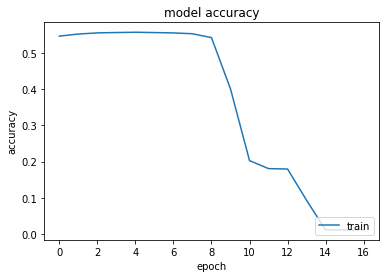

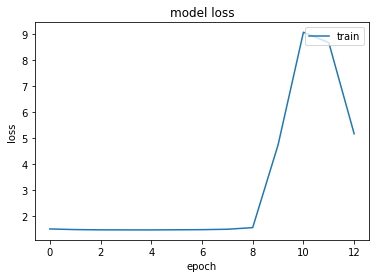

In [19]:
## plot training information
# accuracy
plt.plot(history.history['accuracy']) # kx or similar Matlab commands for plotting
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [30]:
## load a model for testing

# pick your poison
#model_path = os.path.join(save_dir, model_name) # last
model_path = os.path.join(save_dir, best_name) # best

model = load_model(model_path)

print('Loaded', model_path)


Loaded /tf/notebooks/trained_models/2019-12-08_20-37-56_trainedmodel_best.h5


In [31]:
## set for the final output
start_index = random.randint(0, len(text) - maxlen - 1)
sentence = text[start_index: start_index + maxlen]
randomizeOut = False
temperature = 0.5 # 0.5? depends on training length
maxChars = 1000 # 400 is same as above

if randomizeOut:
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence

seed = sentence.replace('\n','')
seed = seed.replace('\t','')
print('*** seed: <', seed ,'>')
#sys.stdout.write(generated)

print('\n',seed, end = '')

for i in range(maxChars):
    x_pred = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(sentence):
        x_pred[0, t, char_indices[char]] = 1.

    preds = model.predict(x_pred, verbose=0)[0]
    next_index = sample(preds, temperature)
    next_char = indices_char[next_index]

    sentence = sentence[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()
print()

*** seed: < erforth, arrived at school. they were no >

 erforth, arrived at school. they were not the second that he said hermione so he was and hermione looking as he had distanted all the crack. "i have not they wave his slight harry to harry said dishad for the floor starting harry. "it was a good that any person and the face of the grounds of the hands ended the startion and come at the sitting to the hear last with hotse to was and the stood and surprised to the partry to the last since it was made purt that and the not seemed a moment as he was the door of the tate entiof and half made that he found him. "you have been here and he are hermione would hear which he sitting to see the top of the start of the start of the prophetily and harry and she caught a face of him. "you did not the for the sign the whole rather sturt of the sounds caught it was better and kind to the still the dark triballes and the common room the looking with his and devermed him and staring at his head wit